In [1]:
import datetime as dt

from IPython.display import Image

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import pandas as pd

import pydotplus

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

In [3]:
ranges_m = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
ranges_d = [0.3, 0.7]
quantiles_d = customer_profile.quantile(q=ranges_d)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
ranges_r = [0.3, 0.8]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r['Recency']

0.3     22.0
0.8    179.0
Name: Recency, dtype: float64

In [6]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreD(x, data, thresh):
    if x <= thresh[data][ranges_d[0]]:
        return 1
    elif x <= thresh[data][ranges_d[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreD, args=('Delta', quantiles_d))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])
#customer_profile.describe()

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)
#quantiles

In [9]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2110
High      1231
Low        981
Name: Label, dtype: int64

In [11]:
'''customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)
customer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)'''

"customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)\ncustomer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)"

In [12]:
'''fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],
           c=customer_labeled['Label_num'])
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()'''

"fig = plt.figure()\nax = Axes3D(fig)\nax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],\n           c=customer_labeled['Label_num'])\nax.set_xlabel('Delta')\nax.set_ylabel('Recency')\nax.set_zlabel('Relative Monetary')\nplt.show()"

In [13]:
# Upsample minority classes

df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=len(df_majority))

df_middle_upsampled = resample(df_middle,
                               replace=True,
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

High      2110
Medium    2110
Low       2110
Name: Label, dtype: int64

In [14]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [15]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Max_items', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [16]:
train_label.head()

4331    0
1318    1
1742    0
2072    1
1911    0
Name: Label_num, dtype: int64

## Decision Tree

In [17]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

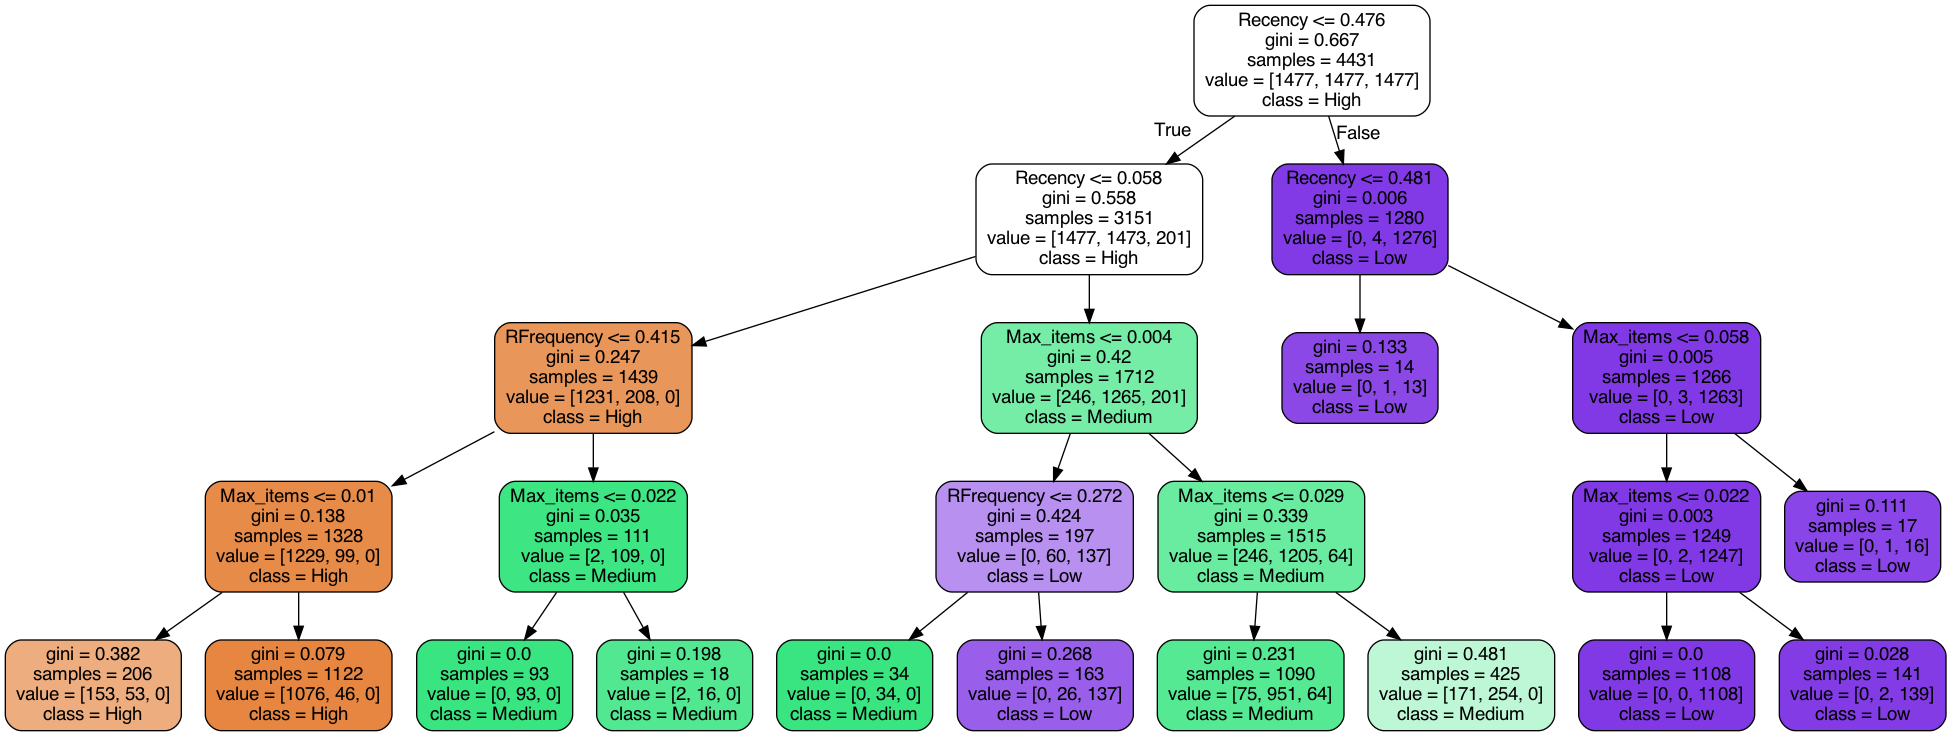

In [18]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency', 'Max_items'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [19]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [20]:
# Evaulate the accuracy and F1 score on the train set and the test set

print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred_dt))
print()
print('F1 score train set:', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('F1 score test set: ', metrics.f1_score(test_label, test_pred_dt, average='weighted'))

#print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set: 0.9004739336492891
Accuracy test set:  0.8957345971563981

F1 score train set: 0.9011734607183202
F1 score test set:  0.8966130895350912


In [21]:
from sklearn.metrics import classification_report

print('Train:')
print(classification_report(train_label,
                            train_pred_dt,
                            target_names=['High', 'Medium','Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_dt,
                            target_names=['High', 'Medium','Low']))

Train:
              precision    recall  f1-score   support

        High       0.93      0.83      0.88      1477
      Medium       0.81      0.91      0.86      1477
         Low       0.98      0.96      0.97      1477

    accuracy                           0.90      4431
   macro avg       0.91      0.90      0.90      4431
weighted avg       0.91      0.90      0.90      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.94      0.81      0.87       633
      Medium       0.79      0.93      0.86       633
         Low       0.98      0.95      0.96       633

    accuracy                           0.90      1899
   macro avg       0.90      0.90      0.90      1899
weighted avg       0.90      0.90      0.90      1899



In [22]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split

from sklearn.model_selection import cross_validate
import statistics 

scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)

print('Fit time:   ', statistics.mean(scores['fit_time']))
print('Score time: ', statistics.mean(scores['score_time']))
print('Test score: ', statistics.mean(scores['test_score']))
print('Train score:', statistics.mean(scores['train_score']))

Fit time:    0.00946346918741862
Score time:  0.0009822845458984375
Test score:  0.9000225682690137
Train score: 0.9004739336492891


In [23]:
# compute confusion matrix

from sklearn.metrics import confusion_matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1229  248    0]
 [  99 1348   30]
 [   0   64 1413]]
------------------
Test:
[[511 122   0]
 [ 32 589  12]
 [  0  32 601]]


## SVM

In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='poly')

In [25]:
# Predictions

train_pred_svm = svm.predict(train_set)
test_pred_svm = svm.predict(test_set)

In [26]:
# Compute the performance of the model

print('Train:')
print(classification_report(train_label,
                            train_pred_svm,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_svm,
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.70      0.98      0.82      1477
      Medium       0.80      0.52      0.63      1477
         Low       0.94      0.88      0.91      1477

    accuracy                           0.80      4431
   macro avg       0.81      0.80      0.79      4431
weighted avg       0.81      0.80      0.79      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.68      0.99      0.81       633
      Medium       0.81      0.49      0.61       633
         Low       0.95      0.90      0.92       633

    accuracy                           0.79      1899
   macro avg       0.81      0.79      0.78      1899
weighted avg       0.81      0.79      0.78      1899



## KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [28]:
train_pred_knn = knn.predict(train_set)
test_pred_knn = knn.predict(test_set)

In [29]:
print('Train:')
print(classification_report(train_label,
                            train_pred_knn,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_knn,
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.89      0.99      0.93      1477
      Medium       0.96      0.86      0.91      1477
         Low       0.98      0.98      0.98      1477

    accuracy                           0.94      4431
   macro avg       0.94      0.94      0.94      4431
weighted avg       0.94      0.94      0.94      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.85      0.95      0.90       633
      Medium       0.90      0.80      0.85       633
         Low       0.96      0.96      0.96       633

    accuracy                           0.90      1899
   macro avg       0.90      0.90      0.90      1899
weighted avg       0.90      0.90      0.90      1899



## Classification with Random Forest

In [30]:
# Define and fit a random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 

rf = rf.fit(train_set, train_label)

In [31]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

In [32]:
print('Train:')
print(classification_report(train_label,
                            train_pred_rf,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_rf,
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.93      0.85      0.89      1477
      Medium       0.83      0.91      0.87      1477
         Low       0.98      0.96      0.97      1477

    accuracy                           0.91      4431
   macro avg       0.91      0.91      0.91      4431
weighted avg       0.91      0.91      0.91      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.94      0.82      0.88       633
      Medium       0.80      0.93      0.86       633
         Low       0.98      0.94      0.96       633

    accuracy                           0.90      1899
   macro avg       0.91      0.90      0.90      1899
weighted avg       0.91      0.90      0.90      1899



## Neural networks

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_labeled[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [35]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
13/13 [==============================] - 0s 19ms/step - loss: 1.0687 - accuracy: 0.4457 - val_loss: 1.0425 - val_accuracy: 0.6323
Epoch 2/40
13/13 [==============================] - 0s 4ms/step - loss: 1.0282 - accuracy: 0.6285 - val_loss: 0.9982 - val_accuracy: 0.6474
Epoch 3/40
13/13 [==============================] - 0s 6ms/step - loss: 0.9829 - accuracy: 0.6366 - val_loss: 0.9416 - val_accuracy: 0.6541
Epoch 4/40
13/13 [==============================] - 0s 5ms/step - loss: 0.9231 - accuracy: 0.6604 - val_loss: 0.8651 - val_accuracy: 0.6782
Epoch 5/40
13/13 [==============================] - 0s 5ms/step - loss: 0.8608 - accuracy: 0.6782 - val_loss: 0.7815 - val_accuracy: 0.7218
Epoch 6/40
13/13 [==============================] - 0s 5ms/step - loss: 0.7858 - accuracy: 0.7085 - val_loss: 0.6996 - val_accuracy: 0.7692
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 0.7103 - accuracy: 0.7440 - val_loss: 0.6174 - val_accuracy: 0.8030
Epoch 8/40
13/13 [=

## Classification with Naive Bayes

In [36]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

In [37]:
print('Train:')
print(classification_report(train_label,
                            train_pred_gnb, 
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_gnb, 
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.76      0.95      0.84      1477
      Medium       0.80      0.62      0.70      1477
         Low       0.92      0.90      0.91      1477

    accuracy                           0.82      4431
   macro avg       0.83      0.82      0.82      4431
weighted avg       0.83      0.82      0.82      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.75      0.94      0.83       633
      Medium       0.80      0.61      0.69       633
         Low       0.92      0.90      0.91       633

    accuracy                           0.82      1899
   macro avg       0.82      0.82      0.81      1899
weighted avg       0.82      0.82      0.81      1899

